In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from cmcrameri import cm
from bem import geometry as gm
from bem import observations
import bem.greensfunctions as GF

# Define the coordinates of the rectangular box domain
H = 1e3
L = H*4
ngrid = 21
# corners = np.array([[-L, 0], [L, 0], [L, -H], [-L, -H], [-L, 0]])
corners = np.array([[-L, 0], [L, 0], 
                    [L, -H], [H, -H], 
                    [0.25*H, -0.75*H], [-0.25*H, -0.75*H], 
                    [-H, -H], [-L, -H], [-L, 0]])

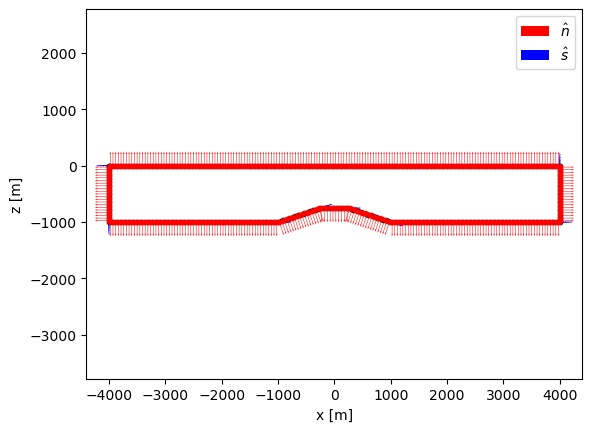

In [70]:
# Create arrays of the x and y coordinates of the corners
x, z = [], []
ni = len(corners[:,0])-1
for i in range(ni):
    lsegment = np.sqrt((corners[i,0]-corners[(i+1),0])**2 + (corners[i,1]-corners[(i+1),1])**2)
    xi = np.linspace(corners[i][0], corners[(i + 1) % ni][0], num=round(lsegment*ngrid/H), endpoint=False)
    zi = np.linspace(corners[i][1], corners[(i + 1) % ni][1], num=round(lsegment*ngrid/H), endpoint=False)
    x.append(xi)
    z.append(zi)
x.append(corners[0,0])
z.append(corners[0,1])
x = np.hstack(x)
z = np.hstack(z)

# create a geometry object with those nodes
rcv = gm(x,z)
# print(rcv.x)

# plot geometry
plt.plot(rcv.xn,rcv.zn,'k.-',linewidth=0.5)
plt.plot(rcv.x,rcv.z,'r.')
plt.quiver(rcv.x,rcv.z,rcv.nv[:,0],rcv.nv[:,1],color='r',width=1e-3,label='$\hat{n}$')
plt.quiver(rcv.x,rcv.z,rcv.dv[:,0],rcv.dv[:,1],color='b',label='$\hat{s}$',width=1e-3)
plt.axis('equal')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.legend()
plt.show()

In [71]:
# compute traction kernels
Ks_s,Kn_s,Ks_n,Kn_n = GF.compute_tractionkernel(rcv,rcv)
# Ks_n - shear traction due to normal slip
# Kn_s - normal traction due to shear slip

# compute displacement kernels
Gx_s,Gz_s,Gx_n,Gz_n = GF.compute_displacementkernel(rcv,rcv)

In [72]:
# assemble boundary conditions as right hand side vector
# s - s (traction) and x (displacement)
# n - n (traction) and z (displacement)
rhs_s = np.zeros((rcv.N,1))
rhs_n = np.zeros((rcv.N,1))

# label boundaries
bcindex_top = (rcv.z==0)
bcindex_left = (rcv.x==-L)
bcindex_right = (rcv.x==L)
bcindex_bot = (~(bcindex_top|bcindex_left|bcindex_right))

# specify whether displacement or traction BCs
# 1 - traction BC
# 0 - displacement BC
# [top_s,top_n,
# bot_s,bot_n,
# left_s,left_n,
# right_s,right_n]
bcindices = np.array([1,1,1,1,\
                      0,0,0,0])

# specify boundary conditions
bc_top_s = np.zeros_like(np.where(bcindex_top)) # zero traction
bc_top_n = np.zeros_like(np.where(bcindex_top)) # zero traction 
rhs_s[bcindex_top,0] = bc_top_s
rhs_n[bcindex_top,0] = bc_top_n

bc_bot_s = np.zeros_like(np.where(bcindex_bot)) # zero traction
bc_bot_n = 0*np.ones_like(np.where(bcindex_bot)) # zero traction/displacements
rhs_s[bcindex_bot,0] = bc_bot_s
rhs_n[bcindex_bot,0] = bc_bot_n

bc_left_s = -1*np.ones_like(np.where(bcindex_left)) # X Dirichlet displacements
# bc_left_s = np.sin(2*np.pi*rcv.z[np.where(bcindex_left)]/H) # X Dirichlet displacements
bc_left_n = 0*np.ones_like(np.where(bcindex_left)) # Z Dirichlet displacements
rhs_s[bcindex_left,0] = bc_left_s
rhs_n[bcindex_left,0] = bc_left_n

bc_right_s = 1*np.ones_like(np.where(bcindex_right)) # X Dirichlet displacements
# bc_right_s = np.sin(2*np.pi*rcv.z[np.where(bcindex_right)]/H)
bc_right_n = -0*np.ones_like(np.where(bcindex_right)) # Z Dirichlet displacements
rhs_s[bcindex_right,0] = bc_right_s
rhs_n[bcindex_right,0] = bc_right_n

rhs = np.concatenate((rhs_s, rhs_n))

# print(rcv.z[np.where(bcindex_left)])

In [73]:
# Construct the matrices for linear inverse problem
# s - s (traction) and x (displacement)
# n - n (traction) and z (displacement)
As_s = np.zeros((rcv.N,rcv.N)) 
An_s = np.zeros((rcv.N,rcv.N)) 

As_n = np.zeros((rcv.N,rcv.N))
An_n = np.zeros((rcv.N,rcv.N))
"""
# top
if bcindices[0]==1:# for shear traction bc
    As_s[np.ix_(bcindex_top,bcindex_top)] = Ks_s[bcindex_top][:,bcindex_top]
    As_n[np.ix_(bcindex_top,bcindex_top)] = Ks_n[bcindex_top][:,bcindex_top]

    As_s[np.ix_(bcindex_top,bcindex_bot)] = Ks_s[bcindex_top][:,bcindex_bot]
    As_n[np.ix_(bcindex_top,bcindex_bot)] = Ks_n[bcindex_top][:,bcindex_bot]

    As_s[np.ix_(bcindex_top,bcindex_left)] = Ks_s[bcindex_top][:,bcindex_left]
    As_n[np.ix_(bcindex_top,bcindex_left)] = Ks_n[bcindex_top][:,bcindex_left]

    As_s[np.ix_(bcindex_top,bcindex_right)] = Ks_s[bcindex_top][:,bcindex_right]
    As_n[np.ix_(bcindex_top,bcindex_right)] = Ks_n[bcindex_top][:,bcindex_right]

else:# for x displacement bc
    As_s[np.ix_(bcindex_top,bcindex_top)] = Gx_s[bcindex_top][:,bcindex_top]    
    # fill these other options in

if bcindices[1]==1: # for normal traction bc
    An_s[np.ix_(bcindex_top,bcindex_top)] = Kn_s[bcindex_top][:,bcindex_top]
    An_n[np.ix_(bcindex_top,bcindex_top)] = Kn_n[bcindex_top][:,bcindex_top]

    An_s[np.ix_(bcindex_top,bcindex_bot)] = Kn_s[bcindex_top][:,bcindex_bot]
    An_n[np.ix_(bcindex_top,bcindex_bot)] = Kn_n[bcindex_top][:,bcindex_bot]

    An_s[np.ix_(bcindex_top,bcindex_left)] = Kn_s[bcindex_top][:,bcindex_left]
    An_n[np.ix_(bcindex_top,bcindex_left)] = Kn_n[bcindex_top][:,bcindex_left]

    An_s[np.ix_(bcindex_top,bcindex_right)] = Kn_s[bcindex_top][:,bcindex_right]
    An_n[np.ix_(bcindex_top,bcindex_right)] = Kn_n[bcindex_top][:,bcindex_right]

else: # for z displacement bc
    An_s[np.ix_(bcindex_top,bcindex_top)] = Gz_s[bcindex_top][:,bcindex_top]

# bottom
if bcindices[2]==1:# for shear traction bc
    As_s[np.ix_(bcindex_bot,bcindex_top)] = Ks_s[bcindex_bot][:,bcindex_top]
    As_n[np.ix_(bcindex_bot,bcindex_top)] = Ks_n[bcindex_bot][:,bcindex_top]

    As_s[np.ix_(bcindex_bot,bcindex_bot)] = Ks_s[bcindex_bot][:,bcindex_bot]
    As_n[np.ix_(bcindex_bot,bcindex_bot)] = Ks_n[bcindex_bot][:,bcindex_bot]

    As_s[np.ix_(bcindex_bot,bcindex_left)] = Ks_s[bcindex_bot][:,bcindex_left]
    As_n[np.ix_(bcindex_bot,bcindex_left)] = Ks_n[bcindex_bot][:,bcindex_left]

    As_s[np.ix_(bcindex_bot,bcindex_right)] = Ks_s[bcindex_bot][:,bcindex_right]
    As_n[np.ix_(bcindex_bot,bcindex_right)] = Ks_n[bcindex_bot][:,bcindex_right]
else:# for x displacement bc
    As_s[np.ix_(bcindex_bot,bcindex_top)] = Gx_s[bcindex_bot][:,bcindex_top]
    As_n[np.ix_(bcindex_bot,bcindex_top)] = Gx_n[bcindex_bot][:,bcindex_top]

    As_s[np.ix_(bcindex_bot,bcindex_bot)] = Gx_s[bcindex_bot][:,bcindex_bot]
    As_n[np.ix_(bcindex_bot,bcindex_bot)] = Gx_n[bcindex_bot][:,bcindex_bot]

    As_s[np.ix_(bcindex_bot,bcindex_left)] = Gx_s[bcindex_bot][:,bcindex_left]
    As_n[np.ix_(bcindex_bot,bcindex_left)] = Gx_n[bcindex_bot][:,bcindex_left]

    As_s[np.ix_(bcindex_bot,bcindex_right)] = Gx_s[bcindex_bot][:,bcindex_right]
    As_n[np.ix_(bcindex_bot,bcindex_right)] = Gx_n[bcindex_bot][:,bcindex_right]

if bcindices[3]==1:# for normal traction bc
    An_s[np.ix_(bcindex_bot,bcindex_top)] = Kn_s[bcindex_bot][:,bcindex_top]
    An_n[np.ix_(bcindex_bot,bcindex_top)] = Kn_n[bcindex_bot][:,bcindex_top]

    An_s[np.ix_(bcindex_bot,bcindex_bot)] = Kn_s[bcindex_bot][:,bcindex_bot]
    An_n[np.ix_(bcindex_bot,bcindex_bot)] = Kn_n[bcindex_bot][:,bcindex_bot]

    An_s[np.ix_(bcindex_bot,bcindex_left)] = Kn_s[bcindex_bot][:,bcindex_left]
    An_n[np.ix_(bcindex_bot,bcindex_left)] = Kn_n[bcindex_bot][:,bcindex_left]

    An_s[np.ix_(bcindex_bot,bcindex_right)] = Kn_s[bcindex_bot][:,bcindex_right]
    An_n[np.ix_(bcindex_bot,bcindex_right)] = Kn_n[bcindex_bot][:,bcindex_right]
else:# for z displacement bc
    An_s[np.ix_(bcindex_bot,bcindex_top)] = Gz_s[bcindex_bot][:,bcindex_top]
    An_n[np.ix_(bcindex_bot,bcindex_top)] = Gz_n[bcindex_bot][:,bcindex_top]

    An_s[np.ix_(bcindex_bot,bcindex_bot)] = Gz_s[bcindex_bot][:,bcindex_bot]
    An_n[np.ix_(bcindex_bot,bcindex_bot)] = Gz_n[bcindex_bot][:,bcindex_bot]

    An_s[np.ix_(bcindex_bot,bcindex_left)] = Gz_s[bcindex_bot][:,bcindex_left]
    An_n[np.ix_(bcindex_bot,bcindex_left)] = Gz_n[bcindex_bot][:,bcindex_left]

    An_s[np.ix_(bcindex_bot,bcindex_right)] = Gz_s[bcindex_bot][:,bcindex_right]
    An_n[np.ix_(bcindex_bot,bcindex_right)] = Gz_n[bcindex_bot][:,bcindex_right]

# left BC
if bcindices[4]==0:# for x displacement BC
    As_s[np.ix_(bcindex_left,bcindex_top)] = Gx_s[bcindex_left][:,bcindex_top]
    As_n[np.ix_(bcindex_left,bcindex_top)] = Gx_n[bcindex_left][:,bcindex_top]

    As_s[np.ix_(bcindex_left,bcindex_bot)] = Gx_s[bcindex_left][:,bcindex_bot]
    As_n[np.ix_(bcindex_left,bcindex_bot)] = Gx_n[bcindex_left][:,bcindex_bot]

    As_s[np.ix_(bcindex_left,bcindex_left)] = Gx_s[bcindex_left][:,bcindex_left]
    As_n[np.ix_(bcindex_left,bcindex_left)] = Gx_n[bcindex_left][:,bcindex_left]

    As_s[np.ix_(bcindex_left,bcindex_right)] = Gx_s[bcindex_left][:,bcindex_right]
    As_n[np.ix_(bcindex_left,bcindex_right)] = Gx_n[bcindex_left][:,bcindex_right]
else:# shear traction BC
    As_s[np.ix_(bcindex_left,bcindex_top)] = Ks_s[bcindex_left][:,bcindex_top]

if bcindices[5]==0: # for z displacement bc
    An_s[np.ix_(bcindex_left,bcindex_top)] = Gz_s[bcindex_left][:,bcindex_top]
    An_n[np.ix_(bcindex_left,bcindex_top)] = Gz_n[bcindex_left][:,bcindex_top]

    An_s[np.ix_(bcindex_left,bcindex_bot)] = Gz_s[bcindex_left][:,bcindex_bot]
    An_n[np.ix_(bcindex_left,bcindex_bot)] = Gz_n[bcindex_left][:,bcindex_bot]

    An_s[np.ix_(bcindex_left,bcindex_left)] = Gz_s[bcindex_left][:,bcindex_left]
    An_n[np.ix_(bcindex_left,bcindex_left)] = Gz_n[bcindex_left][:,bcindex_left]

    An_s[np.ix_(bcindex_left,bcindex_right)] = Gz_s[bcindex_left][:,bcindex_right]
    An_n[np.ix_(bcindex_left,bcindex_right)] = Gz_n[bcindex_left][:,bcindex_right]
else: # normal traction  BC      
    An_s[np.ix_(bcindex_left,bcindex_top)] = Kn_s[bcindex_left][:,bcindex_top]

# right BC
if bcindices[6]==0: # x displacement BC
    As_s[np.ix_(bcindex_right,bcindex_top)] = Gx_s[bcindex_right][:,bcindex_top]
    As_n[np.ix_(bcindex_right,bcindex_top)] = Gx_n[bcindex_right][:,bcindex_top]

    As_s[np.ix_(bcindex_right,bcindex_bot)] = Gx_s[bcindex_right][:,bcindex_bot]
    As_n[np.ix_(bcindex_right,bcindex_bot)] = Gx_n[bcindex_right][:,bcindex_bot]

    As_s[np.ix_(bcindex_right,bcindex_left)] = Gx_s[bcindex_right][:,bcindex_left]
    As_n[np.ix_(bcindex_right,bcindex_left)] = Gx_n[bcindex_right][:,bcindex_left]

    As_s[np.ix_(bcindex_right,bcindex_right)] = Gx_s[bcindex_right][:,bcindex_right]
    As_n[np.ix_(bcindex_right,bcindex_right)] = Gx_n[bcindex_right][:,bcindex_right]
else:
    As_s[np.ix_(bcindex_right,bcindex_top)] = Ks_s[bcindex_right][:,bcindex_top]

if bcindices[7]==0: # z displacement BC
    An_s[np.ix_(bcindex_right,bcindex_top)] = Gz_s[bcindex_right][:,bcindex_top]
    An_n[np.ix_(bcindex_right,bcindex_top)] = Gz_n[bcindex_right][:,bcindex_top]

    An_s[np.ix_(bcindex_right,bcindex_bot)] = Gz_s[bcindex_right][:,bcindex_bot]
    An_n[np.ix_(bcindex_right,bcindex_bot)] = Gz_n[bcindex_right][:,bcindex_bot]

    An_s[np.ix_(bcindex_right,bcindex_left)] = Gz_s[bcindex_right][:,bcindex_left]
    An_n[np.ix_(bcindex_right,bcindex_left)] = Gz_n[bcindex_right][:,bcindex_left]

    An_s[np.ix_(bcindex_right,bcindex_right)] = Gz_s[bcindex_right][:,bcindex_right]
    An_n[np.ix_(bcindex_right,bcindex_right)] = Gz_n[bcindex_right][:,bcindex_right]
else:
    An_s[np.ix_(bcindex_right,bcindex_top)] = Kn_s[bcindex_right][:,bcindex_top]
"""

'\n# top\nif bcindices[0]==1:# for shear traction bc\n    As_s[np.ix_(bcindex_top,bcindex_top)] = Ks_s[bcindex_top][:,bcindex_top]\n    As_n[np.ix_(bcindex_top,bcindex_top)] = Ks_n[bcindex_top][:,bcindex_top]\n\n    As_s[np.ix_(bcindex_top,bcindex_bot)] = Ks_s[bcindex_top][:,bcindex_bot]\n    As_n[np.ix_(bcindex_top,bcindex_bot)] = Ks_n[bcindex_top][:,bcindex_bot]\n\n    As_s[np.ix_(bcindex_top,bcindex_left)] = Ks_s[bcindex_top][:,bcindex_left]\n    As_n[np.ix_(bcindex_top,bcindex_left)] = Ks_n[bcindex_top][:,bcindex_left]\n\n    As_s[np.ix_(bcindex_top,bcindex_right)] = Ks_s[bcindex_top][:,bcindex_right]\n    As_n[np.ix_(bcindex_top,bcindex_right)] = Ks_n[bcindex_top][:,bcindex_right]\n\nelse:# for x displacement bc\n    As_s[np.ix_(bcindex_top,bcindex_top)] = Gx_s[bcindex_top][:,bcindex_top]    \n    # fill these other options in\n\nif bcindices[1]==1: # for normal traction bc\n    An_s[np.ix_(bcindex_top,bcindex_top)] = Kn_s[bcindex_top][:,bcindex_top]\n    An_n[np.ix_(bcindex_top,b

In [74]:
# top
if bcindices[0]==1:# for shear traction bc
    As_s[bcindex_top] = Ks_s[bcindex_top]
    As_n[bcindex_top] = Ks_n[bcindex_top]    

else:# for x displacement bc
    As_s[bcindex_top] = Gx_s[bcindex_top] 
    As_n[bcindex_top] = Gx_n[bcindex_top]

if bcindices[1]==1: # for normal traction bc
    An_s[bcindex_top] = Kn_s[bcindex_top]
    An_n[bcindex_top] = Kn_n[bcindex_top]

else: # for z displacement bc
    An_s[bcindex_top] = Gz_s[bcindex_top]

# bottom
if bcindices[2]==1:# for shear traction bc
    As_s[bcindex_bot] = Ks_s[bcindex_bot]
    As_n[bcindex_bot] = Ks_n[bcindex_bot]

else:# for x displacement bc
    As_s[bcindex_bot] = Gx_s[bcindex_bot]
    As_n[bcindex_bot] = Gx_n[bcindex_bot]

if bcindices[3]==1:# for normal traction bc
    An_s[bcindex_bot] = Kn_s[bcindex_bot]
    An_n[bcindex_bot] = Kn_n[bcindex_bot]

else:# for z displacement bc
    An_s[bcindex_bot] = Gz_s[bcindex_bot]
    An_n[bcindex_bot] = Gz_n[bcindex_bot]

# left BC
if bcindices[4]==0:# for x displacement BC
    As_s[bcindex_left] = Gx_s[bcindex_left]
    As_n[bcindex_left] = Gx_n[bcindex_left]

else:# shear traction BC
    As_s[bcindex_left] = Ks_s[bcindex_left]
    As_n[bcindex_left] = Ks_s[bcindex_left]

if bcindices[5]==0: # for z displacement bc
    An_s[bcindex_left] = Gz_s[bcindex_left]
    An_n[bcindex_left] = Gz_n[bcindex_left]

else: # normal traction  BC      
    An_s[bcindex_left] = Kn_s[bcindex_left]
    An_n[bcindex_left] = Kn_n[bcindex_left]

# right BC
if bcindices[6]==0: # x displacement BC
    As_s[bcindex_right] = Gx_s[bcindex_right]
    As_n[bcindex_right] = Gx_n[bcindex_right]

else:
    As_s[bcindex_right] = Ks_s[bcindex_right]
    As_n[bcindex_right] = Ks_n[bcindex_right]

if bcindices[7]==0: # z displacement BC
    An_s[bcindex_right] = Gz_s[bcindex_right]
    An_n[bcindex_right] = Gz_n[bcindex_right]

else:
    An_s[bcindex_right] = Kn_s[bcindex_right]
    An_n[bcindex_right] = Kn_n[bcindex_right]


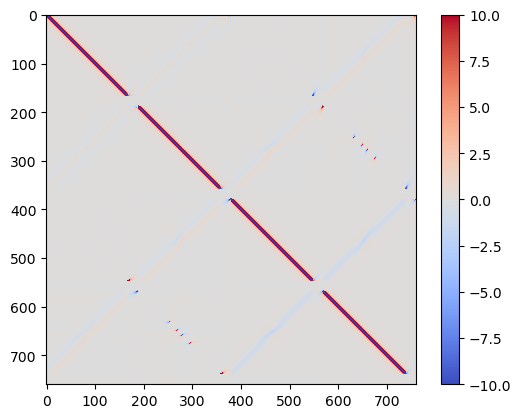

In [75]:
# assemble big matrix
A = np.block([[As_s, As_n], [An_s, An_n]])

# fig, axs = plt.subplots(2, 2, figsize=(5, 5))
# axs[0,0].imshow(As_s,cmap='coolwarm')
# plt.axis('equal')
# axs[0,1].imshow(As_n,cmap='coolwarm')
# plt.axis('equal')
# axs[1,0].imshow(An_s,cmap='coolwarm')
# plt.axis('equal')
# axs[1,1].imshow(An_n,cmap='coolwarm')
# plt.axis('equal')
# plt.show()

plt.imshow(A,cmap = 'coolwarm')
plt.colorbar()
plt.clim((-10,10))
plt.show()


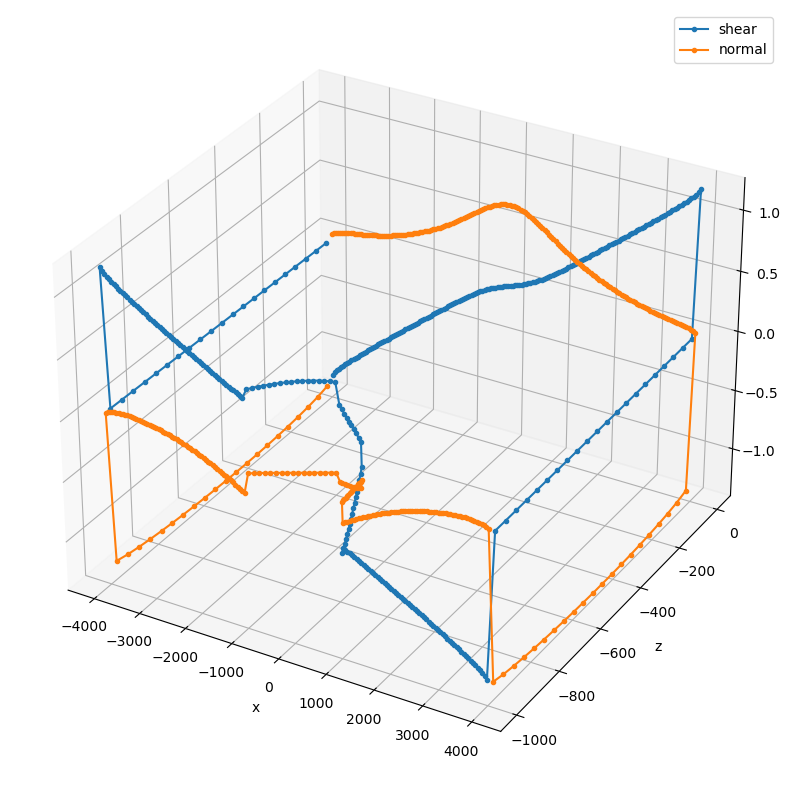

In [76]:
# solve the boundary value problem (BEM solve)
# solvec = np.linalg.solve(A,rhs)
solvec,_,_,_ = np.linalg.lstsq(A, rhs, rcond=None)

# extract solution into slip components for all boundaries
slip_s = solvec[0:rcv.N,0]
slip_n = solvec[rcv.N:,0]

fig = plt.figure()
fig.add_subplot(projection='3d')
fig.set_size_inches((10,10))
plt.plot(rcv.x,rcv.z,slip_s,'.-',label='shear')
plt.plot(rcv.x,rcv.z,slip_n,'.-',label='normal')
plt.legend()
plt.ylabel('z')
plt.xlabel('x')
plt.grid()
plt.show()

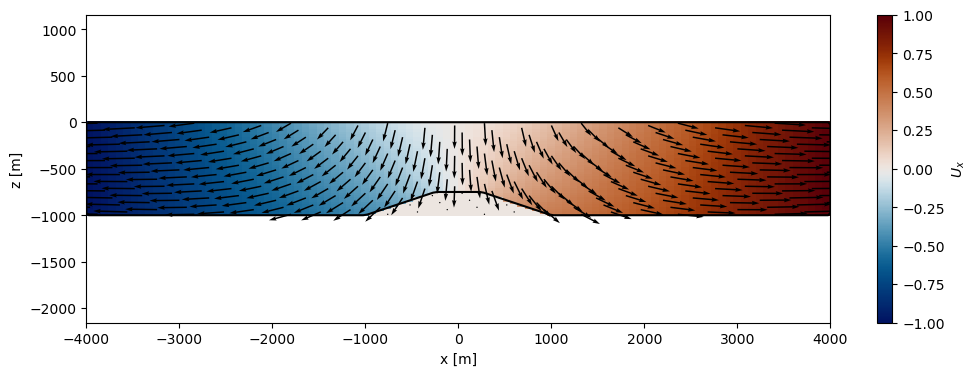

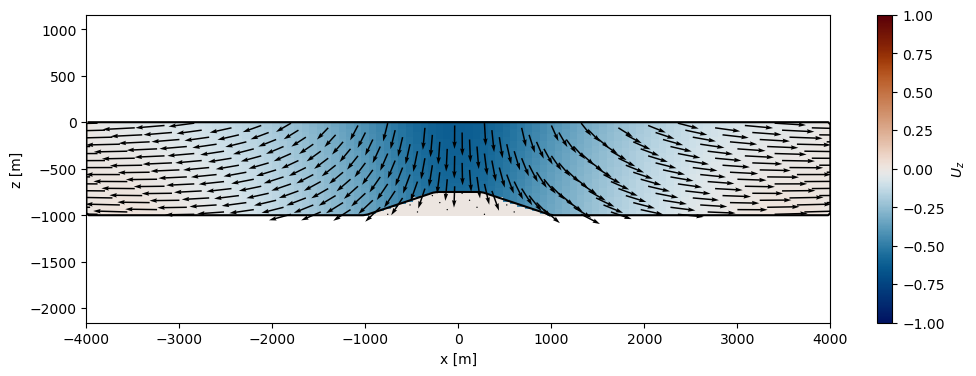

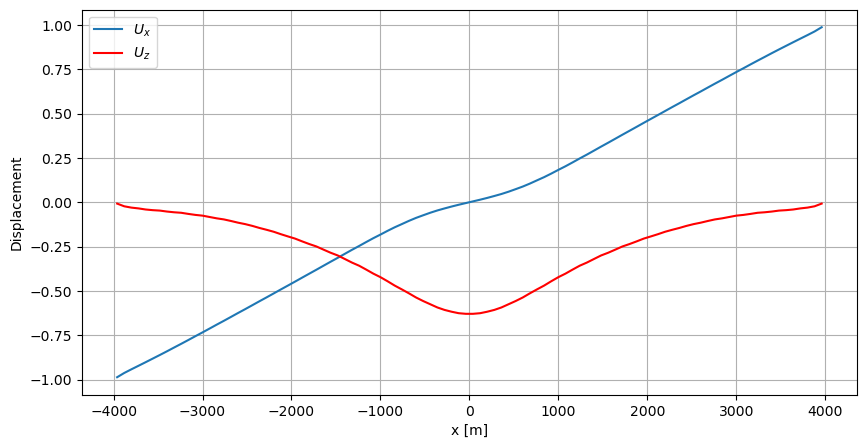

In [77]:
# compute displacements in the medium
xvec = np.linspace(-L*0.99,L*0.99,100)
zvec = np.linspace(-H*0.99,-0.01*H,40)
[X,Z] = np.meshgrid(xvec,zvec)
# create observer object
obs = observations(X.flatten(),Z.flatten())

# compute displacement kernels
Gox_s,Goz_s,Gox_n,Goz_n = GF.compute_displacementkernel(rcv,obs)

# compute internal displacements
x_obs = Gox_s@slip_s + Gox_n@slip_n
z_obs = Goz_s@slip_s + Goz_n@slip_n
# remove values inside cavity
in_path = mpath.Path(np.vstack((rcv.x, rcv.z)).T)
in_idx = in_path.contains_points(np.vstack((obs.x, obs.z)).T)
x_obs[~in_idx] = 0
z_obs[~in_idx] = 0

# grid spacing for arrows
ng = 13

plt.figure(figsize=(12,4))
plt.pcolor(xvec,zvec,x_obs.reshape(len(zvec),len(xvec)),cmap=cm.vik)
plt.clim((-1,1))
plt.colorbar(label='$U_x$')
plt.plot(rcv.x,rcv.z,'k-')
plt.quiver(obs.x[1::ng],obs.z[1::ng],x_obs[1::ng],z_obs[1::ng],width = 2e-3)
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.axis('equal')
plt.show()

plt.figure(figsize=(12,4))
plt.pcolor(xvec,zvec,z_obs.reshape(len(zvec),len(xvec)),cmap=cm.vik)
plt.clim((-1,1))
plt.colorbar(label='$U_z$')
plt.plot(rcv.x,rcv.z,'k-')
plt.quiver(obs.x[1::ng],obs.z[1::ng],x_obs[1::ng],z_obs[1::ng],width = 2e-3)
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.axis('equal')
plt.show()

# plot surface displacements
plt.figure(figsize=(10,5))
index = np.where(obs.z < 0)
idx = (obs.z == np.max(obs.z[index]))
plt.plot(obs.x[idx],x_obs[idx]-0/L*obs.x[idx],'-',label='$U_x$')
# plt.plot(xvec,1/L*xvec,'k-',label='ramp')
plt.plot(obs.x[idx],z_obs[idx],'r-',label='$U_z$')
plt.axis('tight')
plt.xlabel('x [m]')
plt.ylabel('Displacement')
plt.legend()
plt.grid()
plt.show()